# Define

## setting

In [1]:
import torch #基本モジュール
from torch.autograd import Variable #自動微分用
import torch.nn as nn #ネットワーク構築用
import torch.optim as optim #最適化関数
import torch.nn.functional as F #ネットワーク用の様々な関数
import torch.utils.data #データセット読み込み関連
import torchvision #画像関連
from torch import Tensor
from torchvision import datasets, models, transforms #画像用データセット諸々

import numpy as np
import argparse
import json
from logging.config import dictConfig
from logging import getLogger
import os
import time
from google.colab import files
import itertools

## Components

In [2]:
class Zero(nn.Module):
  def __init__(self, stride):
    super(Zero, self).__init__()
    self.stride = stride

  def forward(self, x):
    if self.stride == 1:
      return x.mul(0.)
    return x[:,:,::self.stride,::self.stride].mul(0.)

In [3]:
class FactorizedReduce(nn.Module):
  def __init__(self, C_in, C_out, affine=True):
    super(FactorizedReduce, self).__init__()
    assert C_out % 2 == 0
    self.relu = nn.ReLU(inplace=False)
    self.conv_1 = nn.Conv2d(C_in, C_out // 2, 1, stride=2, padding=0, bias=False)
    self.conv_2 = nn.Conv2d(C_in, C_out // 2, 1, stride=2, padding=0, bias=False) 
    self.bn = nn.BatchNorm2d(C_out, affine=affine)

  def forward(self, x):
    x = self.relu(x)
    # strideの偶奇による情報ロスを防ぐ
    out = torch.cat([self.conv_1(x), self.conv_2(x[:,:,1:,1:])], dim=1)
    out = self.bn(out)
    return out

In [4]:
class ReLUConvBN(nn.Module):

  def __init__(self, C_in, C_out, kernel_size, stride, padding, affine=True):
    super(ReLUConvBN, self).__init__()
    self.op = nn.Sequential(
      nn.ReLU(inplace=False),
      nn.Conv2d(C_in, C_out, kernel_size, stride=stride, padding=padding, bias=False),
      nn.BatchNorm2d(C_out, affine=affine)
    )

  def forward(self, x):
    return self.op(x)

In [5]:
class Edge(nn.Module):
  def __init__(self, operators, theta=None):
    super(Edge, self).__init__()
    self.operators = operators

  def forward(self, input: Tensor, theta: Tensor) -> Tensor:
    return sum(t * op(input) for t, op in zip(theta, self.operators))

In [6]:
class Graph():
  def __init__(self, node_num : int, input : int=1, output : int=1):
    self.node_num = node_num
    self.input = input
    self.output = output
    self.middle = node_num - input - output
    self._graph = self._make_graph(node_num)
    self._order = self._ordered_edges(1)
  
  def edges(self):
    return self._graph

  def _ordered_edges(self, agg : int):
    g = self._graph
    r = [i for i in range(self.node_num)][self.input:-self.output]
    return [[idx for idx, t in enumerate(g) if t[agg] == i] for i in r]

  # edge indices to each intermediate node
  def ordered_edges(self):
    return self._order

  def size(self):
    return len(self._graph)

  def _make_graph(self, num : int):
    l = [i for i in range(num-1)]
    return [c for c in itertools.combinations(l, 2)]

In [7]:
import sys
from graphviz import Digraph

def plot(graph, theta, multi, filename):
  g = Digraph(
      format='png', #pdf
      edge_attr=dict(fontsize='20', fontname="times"),
      node_attr=dict(style='filled', shape='rect', align='center', fontsize='20', height='0.5', width='0.5', penwidth='2', fontname="times"),
      engine='dot')
  g.body.extend(['rankdir=LR'])

  for i in range(graph.node_num):
    color = 'lightblue'
    color = 'darkseagreen2' if graph.input > i else color
    color = 'palegoldenrod' if graph.node_num - graph.output <= i else color
    g.node(str(i), fillcolor=color)
  
  for idx, (s, e) in enumerate(graph.edges()):
    op = [CANDIDATE[i] for i, p in enumerate(theta[idx]) if p >= 1.0]
    if len(op) == 0: continue
    g.edge(str(s), str(e), label=op[0], fillcolor="gray")

  for i in range(graph.node_num - 1 - multi, graph.node_num - 1):
    g.edge(str(i), str(graph.node_num - graph.output), fillcolor="gray")

  g.render(filename, view=True)
  return g

## Module

In [8]:
OPS = {
  'none' : lambda C, stride, affine: Zero(stride),
  'skip_connect' : lambda C, stride, affine: nn.Identity() if stride == 1 else FactorizedReduce(C, C, affine=affine),
  'avg_pool_3x3' : lambda C, stride, affine: nn.Sequential(nn.AvgPool2d(3, stride=stride, padding=1, count_include_pad=False), nn.BatchNorm2d(C, affine=False)),
  'max_pool_3x3' : lambda C, stride, affine: nn.Sequential(nn.MaxPool2d(3, stride=stride, padding=1), nn.BatchNorm2d(C, affine=False)),
  'conv_3x3' : lambda C, stride, affine: nn.Conv2d(C, C, 3, stride=stride, padding=1),
  'conv_5x5' : lambda C, stride, affine: nn.Conv2d(C, C, 5, stride=stride, padding=2),
  'ReLUConvBN' : lambda C, stride, affine: ReLUConvBN(C, C, 3, stride=stride, padding=1),
}

CANDIDATE = [
  'conv_3x3',
  'conv_5x5',
  # 'ReLUConvBN',
  'avg_pool_3x3',
  'max_pool_3x3',
  'skip_connect',
  'none',
]

In [9]:
# TODO : multiple input/output
class Cell(nn.Module):
  def __init__(self, names, graph, cs, multi, reduce=False):
    super(Cell, self).__init__()
    (c_prev, c) = cs
    self.pre = ReLUConvBN(c_prev, c, 1, 1, 0, affine=False)
    self.reduce = reduce
    self.graph = graph
    self.multi = multi
    self.edges = nn.ModuleList(
      [Edge(self._mix_operators(names, c, r)) for r in self.graph.edges()]
    )

  def _mix_operators(self, names, c, r):
    modules = []
    stride = 2 if self.reduce and r[0] < self.graph.input else 1
    # stride = 1
    for name in names:
      modules += [OPS[name](c, stride, False)]
    return nn.ModuleList(modules)

  def forward(self, input: Tensor, theta: Tensor) -> Tensor:
    input = self.pre(input)
    nodes = [input]

    refs = self.graph.edges()
    for idc in self.graph.ordered_edges():
      output = sum(self.edges[idx](nodes[refs[idx][0]], theta[idx]) for idx in idc)
      nodes += [output]
    
    return torch.cat(nodes[-self.multi:], dim=1)

In [10]:
# TODO : multiple input/output
class CellNetwork(nn.Module):
  def __init__(self, depth = 4, node_num = 4, class_num = 10, multi = -1):
    super(CellNetwork, self).__init__()
    self.depth = depth
    self.onehot = False
    self.graph = Graph(node_num)
    self.multi = self.graph.middle if multi <= 0 else multi
    self.init_modules(3, self.multi, class_num)
    self.init_theta()
    
    print(self.graph.edges())

  def is_reduce(self, idx):
    # return idx % 3 == 2
    return self.depth//3 == idx or 2*self.depth//3 == idx

  def init_theta(self, delta=1e-3):
    # normal_theta = torch.zeros(self.graph.size(), len(CANDIDATE), requires_grad=True)
    # reduce_theta = torch.zeros(self.graph.size(), len(CANDIDATE), requires_grad=True)
    normal_theta = delta * torch.randn(self.graph.size(), len(CANDIDATE), requires_grad=True)
    reduce_theta = delta * torch.randn(self.graph.size(), len(CANDIDATE), requires_grad=True)
    self.thetas = [normal_theta, reduce_theta]

  def init_modules(self, c, multi, class_num):
    # stem
    c_n = c * multi
    self.stem = nn.Sequential(
      nn.Conv2d(c, c_n, 3, padding=1, bias=False),
      nn.BatchNorm2d(c_n)
    )

    # cells
    c_n1, c_n = c_n, c
    self.cells = nn.ModuleList()
    for i in range(self.depth):
      if self.is_reduce(i):
        c_n *= 2
      cell = Cell(CANDIDATE, self.graph, (c_n1, c_n), multi, reduce=self.is_reduce(i))
      self.cells += [cell]
      # c_n1, c_n = multi * c_n, multi * c_n
      c_n1 = multi * c_n
    
    # classify
    self.pooling = nn.AdaptiveAvgPool2d(1)
    self.linear = nn.Linear(c_n1, class_num)

  def forward(self, input) -> Tensor:
    s = self.stem(input)

    for idx, cell in enumerate(self.cells):
      theta = self.thetas[1] if cell.reduce else self.thetas[0]
      weights = theta if self.onehot else F.softmax(theta, dim=-1)
      s = cell(s, weights)

    out = self.pooling(s)
    return self.linear(out.view(out.size(0), -1))
  
  def to(self, *args, **kwargs):
    with torch.no_grad():
      for idx, theta in enumerate(self.thetas):
        self.thetas[idx] = theta.to(*args, **kwargs)

    return super(CellNetwork, self).to(*args, **kwargs)

  def learn_theta(self, is_learn: bool):
    for theta in self.thetas:
      theta.requires_grad = is_learn

  def sampling(self, inplace=True):
    def _sampling(theta, degree=2, graph=self.graph, ignore=CANDIDATE.index('none')):
      with torch.no_grad():
        for t in theta:
          t[ignore] = t.min(0).values
          max = t.max(0)
          t[:] = 0.0
          t[max.indices] = max.values

        for edges in graph.ordered_edges():
          values = [(e, theta[e].argmax(), theta[e].max(0).values) for e in edges]
          select = min(len(values), degree)
          edges = sorted(values, key=lambda x: -x[2])[:select]
          
          for (e, o, v) in values:
            theta[e][o] = 0.0
          for (e, o, v) in edges:
            theta[e][o] = 1.0
            
    if inplace:
      for theta in self.thetas:
        _sampling(theta)
        
      self.learn_theta(False)
      self.onehot = True
      self.log()
    else:
      thetas = [theta.detach().clone() for theta in self.thetas]
      for theta in thetas:
        _sampling(theta)
      return thetas
  
  def plot(self, prefix):
    thetas = self.sampling(inplace=False)
    return [plot(self.graph, theta, self.multi, prefix + name)
      for theta, name in zip(thetas, ["normal", "reduce"])]

  def log(self):
    print("Network")
    for theta in self.thetas:
      print(theta)

# Unit Test

In [11]:
import unittest

def tensor_equal(x, y):
  return (torch.sum(x == y) == x.view(-1).shape[0]).item()

class TestEdge(unittest.TestCase):
  def test_id(self):
    input = torch.randn(1, 3, 32, 32)
    operators = [nn.Identity(), None]
    model = Edge(operators, theta=torch.tensor([1.0, 0.0]))
    output = model(input)
    self.assertEqual(tensor_equal(input, output), True)

if __name__ == '__main__':
    unittest.main(argv=['first-arg-is-ignored'], exit=False)

E
ERROR: test_id (__main__.TestEdge)
----------------------------------------------------------------------
Traceback (most recent call last):
  File "<ipython-input-11-7c4fb3f2b357>", line 11, in test_id
    output = model(input)
  File "/usr/local/lib/python3.6/dist-packages/torch/nn/modules/module.py", line 550, in __call__
    result = self.forward(*input, **kwargs)
TypeError: forward() missing 1 required positional argument: 'theta'

----------------------------------------------------------------------
Ran 1 test in 0.020s

FAILED (errors=1)


# Training

## training

In [12]:
def train(model, device, train_loader, optimizer, optimizerB, criterion, logger, class_array):
    model.train()
    class_array = torch.LongTensor(class_array).to(device)
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        if optimizerB != None: optimizerB.zero_grad()
        output = model(data)
        reg = torch.zeros(output.shape[0], 10).to(device)
        reg.index_add_(1, class_array, output)
        loss = criterion(reg, target)
        loss.backward(retain_graph=True)
        optimizer.step()
        if optimizerB != None: optimizerB.step()
        
    return (None, loss.item())

In [13]:
def test(model, device, test_loader, criterion, logger, class_array):
    model.eval()
    test_loss = []
    correct = 0
    class_array = torch.tensor(class_array).to(device)
    with torch.no_grad():
        for batch_idx, (data, target) in enumerate(test_loader):
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss.append(criterion(output, target).item())
            pred = class_array[output.argmax(dim=1, keepdim=True)]
            correct += pred.eq(target.view_as(pred)).sum().item()
            
    test_loss = np.mean(np.array(test_loss))
    accuracy = 100. * correct / len(test_loader.dataset)
    
    return (None, (test_loss, accuracy))

## Utils

In [14]:
from argparse import Namespace
def dictspace(f):
  def inner(**kwds):
    return f(Namespace(**kwds))
  return inner

In [15]:
class Store():
  def __init__(self, dir="result", name="log"):
    self.dict = {}
    self.dir = dir
  
  def add(self, name, value):
    if not name in self.dict:
      self.dict[name] = []
    self.dict[name].append(value)
  
  def save(self, name="log"):
    path = os.path.join(self.dir, name + ".txt")
    with open(path, mode='w') as f:
      f.write("%s" % self.dict)

  def __repr__(self):
    return "store in %s" % self.dict

In [16]:
def SaveModel(name, model, dir="result"):
  path = os.path.join(dir, name + ".pt")
  if not os.path.exists(dir):
    os.mkdir(dir)

  torch.save(model.state_dict(), path)
  # print(os.path.join("/content", result_path))
  # files.download(os.path.join("/content", result_path))

In [17]:
def load_dataset(train=2000, test=500):
  #画像の変形処理
  transform = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
  ])

  transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
  ])

  #CIFAR-10のtrain, testsetのロード
  trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                          download=True, transform=transform)
  testset = torchvision.datasets.CIFAR10(root='./data', train=False, 
                                          download=True, transform=transform_test)
  
  trainset, _ = torch.utils.data.random_split(trainset, [train, 50000-train])
  testset, _ = torch.utils.data.random_split(testset, [test, 10000-test])
  return trainset, testset

In [18]:
class EarlyStopping:
  def __init__(self, dir="min", patent=5):
    self.list = []
    self.best = 0
    self.patent = patent
    self.count = 0
    self.order = dir == "max"

  def step(self, item):
    def _score(item):
      return item * (1 if self.order else -1)

    if len(self.list) == 0:
      self.best = _score(item)

    self.list.append(item)
    item = _score(item)
    if self.best < item:
      self.best = item
      self.count = 0
    else:
      self.count += 1

  def is_stop(self):
    return self.patent <= self.count

## main

In [19]:
def main(description, **kwarg):

  use_cuda = torch.cuda.is_available()
  device = torch.device("cuda" if use_cuda else "cpu")
  print("device is %s" % device)

  trainset, testset = load_dataset()
  kwargs = {'num_workers': 1, 'pin_memory': True} if use_cuda else {}

  class_array = [i for i in range(10)]

  @dictspace
  def learning(args):

    store = Store(dir=args.dir)
    store.add("kwargs", args)

    # instantiate
    model = CellNetwork(depth = args.depth, node_num = args.node, multi=args.multi)
    model.to(device)

    optimizer = optim.SGD(model.parameters(), lr=args.lr, momentum=args.momentum, weight_decay=3e-4)
    optimizer_theta = optim.Adam(model.thetas, lr=args.lr_theta, betas=(0.5, 0.999), weight_decay=1e-3)
    criterion = nn.CrossEntropyLoss()

    trainset, testset = load_dataset(train=args.train_size)
    trainloader = torch.utils.data.DataLoader(trainset, batch_size=args.batch_size, shuffle=False, **kwargs)
    testloader = torch.utils.data.DataLoader(testset, batch_size=args.batch_size, shuffle=False, **kwargs)
    
    # architecture search
    time_sta = time.time()
    accuracy, loss = 0, 1e10
    model.learn_theta(False)
    for epoch in range(args.epochs):
      
      if epoch == args.switch:
        model.learn_theta(True)
        
      model.log()

      (_, loss_train) = train(model, device, trainloader, optimizer, optimizer_theta, criterion, None, class_array)
      (_, (loss_test, acc)) = test(model, device, testloader, criterion, None, class_array)
      
      print('epoch %d, acc %s' % (epoch, acc))
      if epoch >= args.switch and epoch % 10 == 0:
        model.plot(os.path.join(args.dir, "epoch%d_" % epoch))
      store.add("loss", loss_test)
      store.add("acc", acc)

      accuracy, loss = acc, loss_test
      if time.time() - time_sta >= 60 * args.minutes:
        break 

    print("\naccuracy ", accuracy, end=", ")
    print("loss ", loss)
    model.plot(os.path.join(args.dir, "complete_"))
    SaveModel("cell", model, dir=args.dir)

    # relearning
    stop = EarlyStopping(patent=15)
    accuracy, loss = 0, 1e10
    model.sampling()
    remodel = CellNetwork(depth = args.depth, node_num = args.node, multi=args.multi).to(device)
    remodel.thetas = model.thetas
    remodel.sampling()
    model = remodel
    optimizer = optim.SGD(model.parameters(), lr=args.lr, momentum=args.momentum, weight_decay=3e-4)
    for epoch in range(args.epochs):
      
      model.log()

      (_, loss_train) = train(model, device, trainloader, optimizer, None, criterion, None, class_array)
      (_, (loss_test, acc)) = test(model, device, testloader, criterion, None, class_array)
      
      print('epoch %d, acc %s' % (epoch, acc))
      store.add("loss", loss_test)
      store.add("acc", acc)

      accuracy, loss = acc, loss_test
      stop.step(loss_test)
      if stop.is_stop():
        break

    print("\naccuracy ", accuracy, end=", ")
    print("loss ", loss)
    SaveModel("cell", model, dir=args.dir)
    print(store)
    store.save()

    return loss

  import datetime
  dt_now = datetime.datetime.now()
  kwarg['dir'] = dt_now.strftime('%Y_%m_%d %H-%M-%S')
  learning(**kwarg)

In [20]:
if __name__ == '__main__':
  # main("", lr=0.0100, lr_theta=0.0002, batch_size=64, train_size=20000, momentum=0.9, 
  #          epochs=90, switch=30, minutes=180, depth=5, node=7, multi=2)
  # main("", lr=0.0100, lr_theta=0.0002, batch_size=64, train_size=20000, momentum=0.9, 
  #          epochs=90, switch=10, minutes=180, depth=5, node=7, multi=2)
  # main("", lr=0.0050, lr_theta=0.0005, batch_size=64, train_size=4000, momentum=0.9, 
  #          epochs=15, switch=5, minutes=180, depth=4, node=4, multi=2)

SyntaxError: ignored

In [25]:
model = CellNetwork(depth=5, node_num=7, multi=2)

model.thetas[0] = torch.tensor([[0., 1., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0.],
        [0., 0., 0., 1., 0., 0.],
        [1., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0.],
        [0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0.]], 
        # device='cuda:0'
        )
model.thetas[1] = torch.tensor([[0., 1., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0.],
        [0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0.],
        [0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0.]], 
        # device='cuda:0'
        )

model.plot("complete")

[(0, 1), (0, 2), (0, 3), (0, 4), (0, 5), (1, 2), (1, 3), (1, 4), (1, 5), (2, 3), (2, 4), (2, 5), (3, 4), (3, 5), (4, 5)]


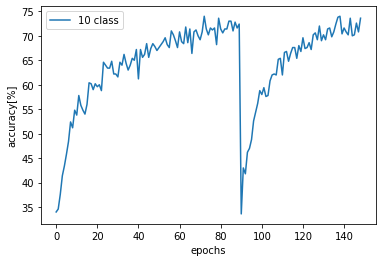

In [29]:

import matplotlib.pyplot as plt
store = Store(dir="")
store.dict = {'kwargs': [Namespace(batch_size=64, depth=5, dir='2020_07_30 20-02-18', epochs=90, lr=0.01, lr_theta=0.0002, minutes=180, momentum=0.9, multi=2, node=7, switch=10, train_size=20000)], 'loss': [1.738662913441658, 1.7356619983911514, 1.646656095981598, 1.6941823661327362, 1.5435153990983963, 1.4588605761528015, 1.4399374276399612, 1.3131541162729263, 1.3259966671466827, 1.2689342647790909, 1.2717725783586502, 1.230916902422905, 1.197055459022522, 1.2699758261442184, 1.3320979326963425, 1.239321231842041, 1.140040673315525, 1.1431667059659958, 1.1942178159952164, 1.1322869583964348, 1.1362876892089844, 1.1113267317414284, 1.157705470919609, 1.0323940515518188, 1.0554631650447845, 1.0449632480740547, 1.029350385069847, 1.0498912706971169, 1.0745915547013283, 1.065494142472744, 1.083207555115223, 1.0563316717743874, 1.0196783393621445, 0.9682072177529335, 0.9992839768528938, 1.0333297327160835, 0.9974660277366638, 0.9718214869499207, 0.9885710850358009, 0.958959773182869, 1.0488664209842682, 0.9509405866265297, 1.0336462780833244, 0.9180182442069054, 0.9315779209136963, 0.9595693349838257, 0.9520016014575958, 0.9400346726179123, 0.8904607072472572, 0.9651626646518707, 0.9195997565984726, 0.9081593900918961, 0.9282623156905174, 0.9186707958579063, 0.9376496598124504, 0.9379294514656067, 0.8782383874058723, 0.8646971210837364, 0.8952257931232452, 0.9277517795562744, 0.8641952127218246, 0.8971780985593796, 0.8794198632240295, 0.8690635785460472, 0.9256779700517654, 0.8553816005587578, 0.98097725212574, 0.8740433230996132, 0.8570373579859734, 0.846257746219635, 0.8909333050251007, 0.8398943096399307, 0.8491236492991447, 0.8646705970168114, 0.9053990095853806, 0.8423657715320587, 0.8841990604996681, 0.8622269779443741, 0.9256073832511902, 0.8334379121661186, 0.8689559623599052, 0.8394221141934395, 0.8335783183574677, 0.8725290969014168, 0.8466307818889618, 0.8028268367052078, 0.8550450950860977, 0.8468340337276459, 0.9337365552783012, 0.8383270278573036, 1.746983453631401, 1.5647589564323425, 1.55721016228199, 1.4600552022457123, 1.3998150676488876, 1.364358738064766, 1.2735487967729568, 1.2362364083528519, 1.2210294306278229, 1.1371358036994934, 1.1427761316299438, 1.104442797601223, 1.140660047531128, 1.0790505558252335, 1.0774997100234032, 1.0536075457930565, 1.0207853764295578, 1.0056785717606544, 0.9881661534309387, 1.0195807367563248, 1.0103375166654587, 0.9184440523386002, 0.9778897240757942, 0.9731171578168869, 0.9225601926445961, 0.9454245120286942, 0.9613457173109055, 0.9550659656524658, 0.915620781481266, 0.952873520553112, 0.9086428433656693, 0.9044419825077057, 0.927307702600956, 0.8931958898901939, 0.8740130215883255, 0.8668570443987846, 0.8324398696422577, 0.8750342652201653, 0.8160704970359802, 0.8380294293165207, 0.8530085682868958, 0.8431418761610985, 0.8052427619695663, 0.796996034681797, 0.8297187387943268, 0.8491935506463051, 0.802898608148098, 0.8054222837090492, 0.8088263273239136, 0.8442801088094711, 0.8164851814508438, 0.8520776927471161, 0.835324838757515, 0.866848312318325, 0.8783451616764069, 0.8645045459270477, 0.8065860718488693, 0.8426506221294403, 0.7975980192422867], 'acc': [34.0, 34.6, 37.6, 41.4, 43.4, 45.8, 48.4, 52.4, 51.2, 54.8, 53.8, 57.8, 55.8, 54.8, 54.0, 56.0, 60.4, 60.2, 59.0, 60.2, 59.6, 60.0, 58.8, 64.6, 64.0, 63.4, 63.4, 64.8, 62.2, 62.2, 61.6, 64.6, 64.0, 66.2, 64.4, 63.0, 64.0, 65.4, 65.0, 67.2, 61.2, 67.2, 65.6, 66.2, 68.4, 65.6, 67.4, 68.4, 67.8, 67.0, 67.6, 68.2, 68.8, 69.6, 68.2, 67.6, 71.0, 70.2, 69.0, 67.6, 70.8, 68.8, 68.4, 71.8, 68.6, 71.4, 66.4, 70.8, 71.2, 70.0, 69.2, 70.8, 74.0, 71.4, 70.2, 71.6, 71.2, 71.6, 68.2, 73.6, 71.4, 70.6, 71.4, 71.4, 73.0, 73.0, 71.0, 72.8, 71.6, 72.4, 33.6, 43.0, 41.8, 46.2, 47.0, 48.8, 52.6, 54.4, 56.2, 58.8, 58.0, 59.4, 57.6, 57.8, 60.8, 62.0, 62.2, 62.0, 65.2, 65.4, 62.0, 66.6, 66.8, 64.8, 66.4, 67.6, 67.6, 65.4, 68.0, 66.8, 69.6, 67.4, 67.6, 68.6, 67.2, 70.2, 70.6, 69.2, 72.0, 69.0, 70.2, 69.2, 71.4, 71.6, 69.8, 70.8, 72.4, 73.8, 74.0, 70.4, 71.6, 70.8, 70.2, 73.6, 70.0, 70.2, 72.6, 70.8, 73.6]}
store.save()
times = len(store.dict['acc'])
fig = plt.figure()
plt.plot(np.arange(times), store.dict['acc'], label="10 class")
plt.xlabel("epochs")
plt.ylabel("accuracy[%]")
plt.legend()
plt.show()
fig.savefig(os.path.join("", "accuracy.png"))